In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import itertools
import string
from tqdm import tqdm_notebook as tqdm

from gensim.models import *

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import *
from keras.models import *
import keras.backend as K
from keras.utils import np_utils

from keras.callbacks import *

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

/home/bharaj/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [3]:
from keras import regularizers
from numpy import array
from numpy import asarray
from numpy import zeros

In [26]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="2"

In [27]:
def plot_confusion_matrix(cm, classes, title='Confusion matrix', cmap=plt.cm.Blues):

    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=25)
    #plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90, fontsize=15)
    plt.yticks(tick_marks, classes, fontsize=15)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black", fontsize = 14)

    plt.ylabel('True label', fontsize=20)
    plt.xlabel('Predicted label', fontsize=20)

In [28]:
### READ DATA ###

df = pd.read_csv('whole_mal.tsv',sep='\t',names=['category','text'])

print(df.shape)
df.head()

(6739, 2)


,category,text
0,unknown state,Ichayan fans pinne mmade ettan fansm ivde oru...
1,not-malayalam,Tovi 🥰 Best Wishes From #Kunjikka Fans
2,unknown state,Urutty koll .nallavanaaya unniyaya saiju kuru...
3,not-malayalam,Pls support me pls My channel subscribe...
4,Positive,Kalki super hit akum enn Bonny parayan paranju


In [29]:
### LABEL DISTRIBUTION ###

df.category.value_counts().plot.pie(figsize=(6,6))

In [30]:
### SIMPLE CLEAN OF TEXT ###

df['text'] = df.text.str.lower().str.replace(r'['+string.digits+string.punctuation+']', ' ')
df['text'] = df['text'].apply(lambda x: x.split())

In [31]:

#y = df['category'].tolist()
#y=np.array(y)
#type(y)

In [32]:
### SPLIT INTO TRAIN/TEST ###
y=df['category']
#y = pd.get_dummies(df['category']).values

X_train, X_test, y_train, y_test = train_test_split(df['text'].tolist(), y, random_state=5, test_size=0.2)

In [33]:
print(type(y_train))
y_train.head()

<class 'pandas.core.series.Series'>


4616         Positive 
5193         Positive 
4502    not-malayalam 
4186         Positive 
4037    unknown state 
Name: category, dtype: object

In [34]:
from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(y_train),
                                                 y_train)

In [35]:
y_train=pd.get_dummies(y_train).values

In [36]:
y_test=pd.get_dummies(y_test).values
y_test

array([[0, 0, 0, 0, 1],
       [0, 0, 0, 0, 1],
       [0, 1, 0, 0, 0],
       ...,
       [0, 1, 0, 0, 0],
       [0, 0, 0, 1, 0],
       [0, 0, 0, 0, 1]], dtype=uint8)

In [37]:
print(X_train[0],y[0])

['ente', 'ponnnuuuuuuu', 'lalettaaa', 'baaki', 'oke', 'kili', 'vannit', 'parayam'] unknown state 


In [38]:
### MAP LABEL ###

diz_label = {}
for i,label in enumerate(df.category.factorize()[1]):
    diz_label[i] = label
    
diz_label

{0: 'unknown state ',
 1: 'not-malayalam ',
 2: 'Positive ',
 3: 'Negative ',
 4: 'Mixed feelings '}

In [39]:
### TRAIN WORD2VEC AND FASTTEXT ###

w2v = Word2Vec(size=100, window=5, min_count=4, seed=33)
w2v.build_vocab(X_train)
w2v.train(X_train, total_examples=w2v.corpus_count, epochs=10)

ft = FastText(size=100, window=5, min_count=4, seed=33)
ft.build_vocab(X_train)
ft.train(X_train, total_examples=ft.corpus_count, epochs=10)

In [40]:
### TRANSFORM ORIGINAL TEXT INTO SEQUENCES AND COMPUTE PADDING ###

max_len = 200

tokenizer = Tokenizer(lower=True, split='')
tokenizer.fit_on_texts(X_train)

sequence_train = tokenizer.texts_to_sequences(X_train)
sequence_train = pad_sequences(sequence_train, maxlen=max_len)

sequence_test = tokenizer.texts_to_sequences(X_test)
sequence_test = pad_sequences(sequence_test, maxlen=max_len)

sequence_train = np.asarray(sequence_train)
sequence_test = np.asarray(sequence_test)

print(sequence_train.shape, sequence_test.shape)

(5391, 200) (1348, 200)


In [41]:
embeddings_dictionary = dict()
glove_file = open('/home/bharaj/third_work/tools/fastText/word_vectors/ml_roman.vec', encoding="utf8")

In [42]:
for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = asarray(records[1:], dtype='float32')
    embeddings_dictionary [word] = vector_dimensions

glove_file.close()

In [43]:
embedding_matrix_fasttext_ml_roman = zeros((len(tokenizer.word_index) + 1, 100))
pas = 0
for word,i in tokenizer.word_index.items():    
    try:
        embedding_vector = embeddings_dictionary.get(word)
        embedding_matrix_fasttext_ml_roman[i] = embedding_vector
    except:
        pas+=1
        
print('not in vocabulary', pas)

not in vocabulary 1763


In [21]:
## GET TRAINED WEIGHTS FOR EACH WORD FROM WORD2VEC ###

embedding_matrix_w2v = np.random.random((len(tokenizer.word_index) + 1, 100))

pas = 0
for word,i in tokenizer.word_index.items():
    
    try:
        embedding_matrix_w2v[i] = w2v.wv[word]
    except:
        pas+=1
        
print('not in vocabulary', pas)

In [21]:
### GET TRAINED WEIGHTS FOR EACH WORD FROM FASTTEXT ###

embedding_matrix_ft = np.random.random((len(tokenizer.word_index) + 1, 100))

pas = 0
for word,i in tokenizer.word_index.items():
    
    try:
        embedding_matrix_ft[i] = ft.wv[word]
    except:
        pas+=1
        
print('not in vocabulary', pas)

not in vocabulary 0


In [24]:
### TRY Concat_Emb ###
read_emb = Concat_Emb([embedding_matrix_fasttext_ml_roman, embedding_matrix_ft], maxlen=max_len)
#read_emb = Concat_Emb([embedding_matrix_w2v, embedding_matrix_ft], maxlen=max_len)
read_emb.summary()

W0110 15:29:51.868969 139771456558848 deprecation_wrapper.py:119] From /home/bharaj/anaconda3/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0110 15:29:51.970487 139771456558848 deprecation_wrapper.py:119] From /home/bharaj/anaconda3/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0110 15:29:51.978865 139771456558848 deprecation_wrapper.py:119] From /home/bharaj/anaconda3/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0110 15:29:51.995384 139771456558848 deprecation_wrapper.py:119] From /home/bharaj/anaconda3/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_se

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 200)          0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 200)          0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 200, 100)     1371200     input_1[0][0]                    
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 200, 100)     1371200     input_2[0][0]                    
__________________________________________________________________________________________________
reshape_1 

In [25]:
### DEFINE DME AND CDME BLOCKS ###

def DME(maxlen):

    inp = Input(shape=(maxlen, 100, 2))
    x = Reshape((maxlen, -1))(inp)
    #x=Masking(mask_value=0)(x)
    x = LSTM(2, return_sequences=True)(x)
    x = Activation('sigmoid')(x)
    x = Reshape((maxlen, 1, 2))(x)
    x = multiply([inp, x])
    out = Lambda(lambda t: K.sum(t, axis=-1))(x)
    
    return Model(inp, out)

def CDME(maxlen, latent_dim=2):
    
    inp = Input(shape=(maxlen, 100, 2))
    x = Reshape((maxlen, -1))(inp)
    x = Bidirectional(LSTM(latent_dim, return_sequences=True))(x)
    x = Lambda(lambda t: [t[:,:,:int(latent_dim/2+1)], t[:,:,int(latent_dim/2+1):]])(x)
    x = Maximum()(x)
    x = Activation('sigmoid')(x)
    x = Reshape((maxlen, 1, 2))(x)
    x = multiply([inp, x])
    out = Lambda(lambda t: K.sum(t, axis=-1))(x)
    
    return Model(inp, out)

In [26]:
class_weights = dict(enumerate(class_weights))

In [34]:
### DEFINE NETWORK WITH DME ###
concat_inp = Concat_Emb([embedding_matrix_fasttext_ml_roman, embedding_matrix_ft], maxlen=max_len)
#concat_inp = Concat_Emb([embedding_matrix_w2v, embedding_matrix_ft], maxlen=max_len)
dme = DME(max_len)
x = dme(concat_inp.output)
x= Masking(mask_value=0)(x)
x = Bidirectional(LSTM(128, dropout=0.2, return_sequences=True))(x)
x = Bidirectional(LSTM(32, dropout=0.2))(x)
out = Dense(y_train.shape[1], activation='softmax',kernel_regularizer=regularizers.l1(0.01))(x)

dme_model = Model(concat_inp.input, out)
dme_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience=10)
mc = ModelCheckpoint('best_DME_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)
dme_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            (None, 200)          0                                            
__________________________________________________________________________________________________
input_7 (InputLayer)            (None, 200)          0                                            
__________________________________________________________________________________________________
embedding_5 (Embedding)         (None, 200, 100)     1371200     input_6[0][0]                    
__________________________________________________________________________________________________
embedding_6 (Embedding)         (None, 200, 100)     1371200     input_7[0][0]                    
__________________________________________________________________________________________________
reshape_7 

In [ ]:
history=dme_model.fit([sequence_train]*2, y_train, batch_size=128, epochs=20, verbose=2, validation_split=0.1,class_weight=class_weights,callbacks=[es,mc])

Train on 4851 samples, validate on 540 samples
Epoch 1/20
 - 102s - loss: nan - acc: 0.0623 - val_loss: nan - val_acc: 0.0574

Epoch 00001: val_acc improved from -inf to 0.05741, saving model to best_DME_model.h5
Epoch 2/20
 - 92s - loss: nan - acc: 0.0623 - val_loss: nan - val_acc: 0.0574

Epoch 00002: val_acc did not improve from 0.05741
Epoch 3/20
 - 92s - loss: nan - acc: 0.0623 - val_loss: nan - val_acc: 0.0574

Epoch 00003: val_acc did not improve from 0.05741
Epoch 4/20


In [29]:
dme_model=load_model('best_DME_model.h5')

In [30]:
print(classification_report([diz_label[i] for i in np.argmax(y_test, axis=1)], 
                            [diz_label[i] for i in np.argmax(dme_model.predict([sequence_test]*2), axis=1)]))

                 precision    recall  f1-score   support

Mixed feelings        0.00      0.00      0.00       398
      Negative        0.00      0.00      0.00       177
      Positive        0.00      0.00      0.00       565
 not-malayalam        0.00      0.00      0.00       138
 unknown state        0.05      1.00      0.10        70

      micro avg       0.05      0.05      0.05      1348
      macro avg       0.01      0.20      0.02      1348
   weighted avg       0.00      0.05      0.01      1348



/home/bharaj/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


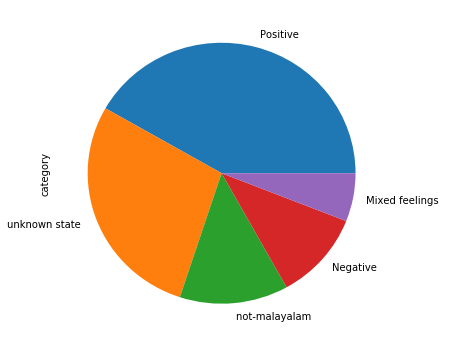

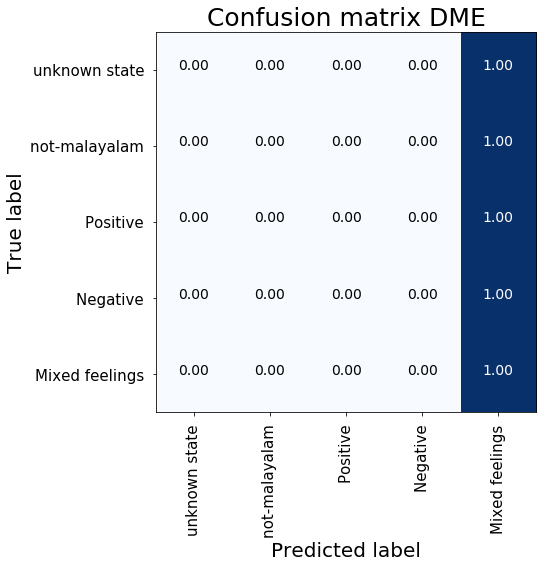

In [31]:
cnf_matrix = confusion_matrix([diz_label[i] for i in np.argmax(y_test, axis=1)], 
                              [diz_label[i] for i in np.argmax(dme_model.predict([sequence_test]*2), axis=1)])

plt.figure(figsize=(7,7))
plot_confusion_matrix(cnf_matrix, classes=list(diz_label.values()), title="Confusion matrix DME")
plt.show()

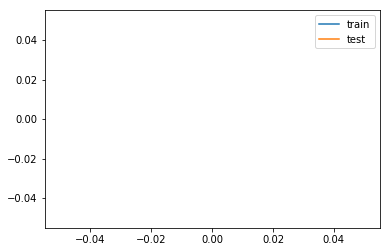

In [32]:
from matplotlib import pyplot
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [33]:
### DEFINE NETWORK WITH CDME ###

concat_inp = Concat_Emb([embedding_matrix_fasttext_ml_roman, embedding_matrix_ft], maxlen=max_len)
cdme = CDME(max_len)
x = cdme(concat_inp.output)
x=Masking(mask_value=0)(x)
x = Bidirectional(LSTM(128, dropout=0.2, return_sequences=True))(x)
x = Bidirectional(LSTM(32, dropout=0.2))(x)
out = Dense(y_train.shape[1], activation='softmax',kernel_regularizer=regularizers.l1(0.01))(x)

cdme_model = Model(concat_inp.input, out)
cdme_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience=10)
mc = ModelCheckpoint('best_CDME_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)
cdme_model.summary()

NameError: name 'embedding_matrix_w2v' is not defined

In [ ]:
history=cdme_model.fit([sequence_train]*2, y_train, batch_size=128, epochs=20, verbose=2, validation_split=0.1,class_weight=class_weights,callbacks=[es,mc])

In [ ]:
cdme_model=load_model('best_CDME_model.h5')

In [ ]:
print(classification_report([diz_label[i] for i in np.argmax(y_test, axis=1)], 
                            [diz_label[i] for i in np.argmax(cdme_model.predict([sequence_test]*2), axis=1)]))

In [ ]:
cnf_matrix = confusion_matrix([diz_label[i] for i in np.argmax(y_test, axis=1)], 
                              [diz_label[i] for i in np.argmax(cdme_model.predict([sequence_test]*2), axis=1)])

plt.figure(figsize=(7,7))
plot_confusion_matrix(cnf_matrix, classes=list(diz_label.values()), title="Confusion matrix CDME")
plt.show()

In [ ]:
from matplotlib import pyplot
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()